In [196]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 


In [197]:
train_df=pd.read_csv("Train_Data.csv")
test_df=pd.read_csv("Test_Data.csv")
sample_submission = pd.read_csv("Sample_Submission.csv")

In [198]:
train_df.head()

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [199]:
train_Data_clean=train_df.drop("SEQN",axis=1)
test_Data_clean=test_df.drop("SEQN",axis=1)

In [200]:
train_df.head()

,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN,age_group
0,73564.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91,Adult
1,73568.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85,Adult
2,73576.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14,Adult
3,73577.0,1.0,2.0,28.9,104.0,NaN,84.0,16.15,Adult
4,73580.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92,Adult


In [201]:
train_df.isna().sum()

SEQN         12
RIAGENDR     18
PAQ605       13
BMXBMI       18
LBXGLU       13
DIQ010       18
LBXGLT       11
LBXIN         9
age_group    14
dtype: int64

In [202]:
train_clean = train_df.drop(columns=["SEQN"])
test_clean = test_df.drop(columns=["SEQN"])

In [203]:
# Drop rows with missing target
train_clean = train_clean.dropna(subset=["age_group"])

In [204]:
# Separate features and target
X = train_clean.drop(columns=["age_group"])
y = train_clean["age_group"].map({"Adult": 0, "Senior": 1})

In [205]:
# Impute missing values using mean
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)
test_imputed = imputer.transform(test_clean)

In [206]:
# Train/test split for validation
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.2, random_state=42)


In [207]:
# Train a Random Forest model
model = RandomForestClassifier(random_state=42, class_weight='balanced')

model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [208]:
y_pred_val = model.predict(X_val)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       340
           1       0.48      0.20      0.28        51

    accuracy                           0.87       391
   macro avg       0.68      0.58      0.60       391
weighted avg       0.84      0.87      0.84       391



In [209]:
# Predict on test data
test_preds = model.predict(test_imputed)


# # Save submission
# submission = pd.DataFrame({'age_group': test_preds})
# submission.to_csv("submission.csv", index=False)

In [210]:
# Calculate scale_pos_weight = (negative class / positive class)
from collections import Counter
class_counts = Counter(y)
scale_pos_weight = class_counts[0] / class_counts[1]  # Adult / Senior

In [211]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y)

# Then split
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [212]:
from xgboost import XGBClassifier
# Train XGBoost classifier
model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)

c:\Users\amank\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:10:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [213]:
y_pred_val = model.predict(X_val)
print(classification_report(y_val, y_pred_val))



              precision    recall  f1-score   support

           0       0.95      0.78      0.86       351
           1       0.79      0.95      0.87       305

    accuracy                           0.86       656
   macro avg       0.87      0.87      0.86       656
weighted avg       0.88      0.86      0.86       656



In [214]:
# Predict on test data
test_preds = model.predict(test_imputed)

In [215]:
submission = pd.DataFrame({'age_group': test_preds})
submission.to_csv("submission.csv", index=False)

In [216]:
submission = pd.read_csv("submission.csv")

# Basic checks
print("Shape:", submission.shape)
print("Unique values:", submission['age_group'].unique())
print(submission.head())

Shape: (312, 1)
Unique values: [0 1]
   age_group
0          0
1          1
2          0
3          0
4          0


In [217]:
# Load test and submission
test = pd.read_csv("Test_Data.csv")
submission = pd.read_csv("submission.csv")

# Combine them
test_with_preds = test.copy()
test_with_preds['predicted_age_group'] = submission['age_group']

# View results
print(test_with_preds.head())

      SEQN  RIAGENDR  PAQ605  BMXBMI  LBXGLU  DIQ010  LBXGLT  LBXIN  \
0  77017.0       1.0     1.0    32.2    96.0     2.0   135.0  15.11   
1  75580.0       2.0     2.0    26.3   100.0     2.0   141.0  15.26   
2  73820.0       1.0     2.0    28.6   107.0     2.0   136.0   8.82   
3  80489.0       2.0     1.0    22.1    93.0     2.0   111.0  12.13   
4  82047.0       1.0     1.0    24.7    91.0     2.0   105.0   3.12   

   predicted_age_group  
0                    0  
1                    1  
2                    0  
3                    0  
4                    0  


In [218]:
test_with_preds['predicted_age_group'].value_counts(normalize=True)


predicted_age_group
0    0.75
1    0.25
Name: proportion, dtype: float64

In [219]:
test_with_preds.groupby('predicted_age_group').mean(numeric_only=True)


,SEQN,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
predicted_age_group,,,,,,,,
0,78616.706897,1.527897,1.759657,27.654936,97.184549,2.021459,103.991379,12.209871
1,79017.256410,1.506494,1.935897,28.275641,108.679487,2.012821,144.730769,10.043205


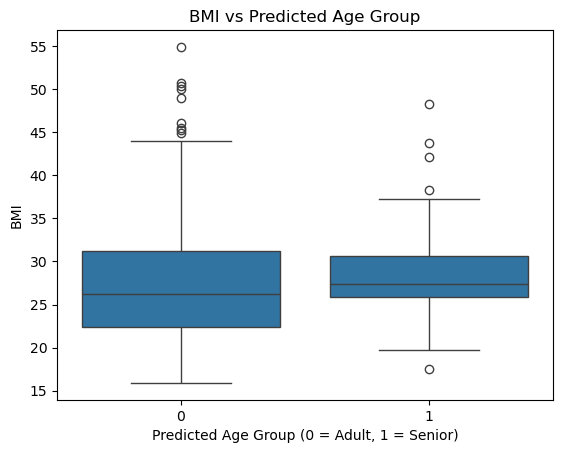

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='predicted_age_group', y='BMXBMI', data=test_with_preds)
plt.title("BMI vs Predicted Age Group")
plt.xlabel("Predicted Age Group (0 = Adult, 1 = Senior)")
plt.ylabel("BMI")
plt.show()
